In [1]:
!pip install pyspark

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F

from google.colab import drive
drive.mount('/content/drive')

INPUT_DATA_PATH  = "/content/drive/MyDrive/basic_features"

Mounted at /content/drive


In [3]:
# Téléchargement des données à partir du repo git
!wget "https://github.com/ettouilebouael/pyspark_for_datascience/raw/refs/heads/main/data/walmart_data.zip"

# Création d'un dossier pour les données walmart
!mkdir walmart_data

# Décompression du fichier zip contenant les données
!unzip walmart_data.zip -d walmart_data

--2024-11-27 19:11:55--  https://github.com/ettouilebouael/pyspark_for_datascience/raw/refs/heads/main/data/walmart_data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ettouilebouael/pyspark_for_datascience/refs/heads/main/data/walmart_data.zip [following]
--2024-11-27 19:11:55--  https://media.githubusercontent.com/media/ettouilebouael/pyspark_for_datascience/refs/heads/main/data/walmart_data.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132754996 (127M) [application/zip]
Saving to: ‘walmart_data.zip’

walmart_data.zip    100%[===================>] 126.60M   132MB/s  

In [4]:
spark = SparkSession.builder.getOrCreate()

In [4]:
INPUT_DATA_PATH = "/content/drive/MyDrive/data_td3_df"

In [5]:
df = spark.read.parquet(INPUT_DATA_PATH)

In [12]:
sell_prices_df = spark.read.parquet("/content/walmart_data/sell_prices.parquet")
sell_prices_df.printSchema()

root
 |-- store_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- wm_yr_wk: long (nullable = true)
 |-- sell_price: double (nullable = true)



In [5]:
calendar_df = spark.read.parquet("/content/walmart_data/calendar.parquet")
calendar_df = calendar_df.withColumn("date", F.to_date(F.col("date"), "yyyy-MM-dd"))
calendar_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- wm_yr_wk: long (nullable = true)
 |-- weekday: string (nullable = true)
 |-- wday: long (nullable = true)
 |-- month: long (nullable = true)
 |-- year: long (nullable = true)
 |-- d: string (nullable = true)
 |-- event_name_1: string (nullable = true)
 |-- event_type_1: string (nullable = true)
 |-- event_name_2: string (nullable = true)
 |-- event_type_2: string (nullable = true)
 |-- snap_CA: long (nullable = true)
 |-- snap_TX: long (nullable = true)
 |-- snap_WI: long (nullable = true)



# Documentation

La documentation ci-dessous contient une description des bases de données d'entrée et de sortie après les différentes manipulations effectuées jusqu'à ce jour. Cette documentation sera donc mise à jour à chaque étape de la réalisation du projet. Cette même documentation est également disponible sur ce [répertoire GitHub](https://github.com/Praedyth9/pyspark_data_walmart/tree/main).


## **Bases de données fournies par Walmart** 🖥

Nous basons notre étude sur trois bases de données fournies par Walmart relatifs aux ventes des produits dans dix de leur magasins entre janvier 2011 et avril 2016. Ces trois bases sont les suivantes :

- `sell_prices` : contient la liste des produits de chaque magasin ainsi que leur prix associé de manière hebdomadaire sous le format suivant :    
```
store_id | item_id | wm_yr_wk | sell_price
```
où `wm_yr_wk`correspond à un numéro attribué à une semaine en particulier.

- `calendar` : Pour chaque jour de la période à laquelle on s'interesse, indique si un évènement spécial se produit ou non (superbowl, période de Noêl, ...). Permet également de lier une semaine donnée au numéro `wm_yr_wk` et est organisé comme suit :    
```
date | wm_yr_wk | weekday | wday | month | year | event...
```
- `walmart_sales` : Répertorie les ventes journaliaires de chaque produit dans chaque magasin sous le format décrit ci-dessous :    
```
item_id | dept_id | cat_id | store_id | state_id | id | date | sales
```

## **Objectifs du projet** 🎯

L'objectif du projet est d'utiliser les bases de données fournies par Walmart afin de développer un modèle prédictif en PySpark afin d'estimer les ventes mensuelles dans chacun des 10 magasins faisant parti de la cohorte étudiée. Pour ce faire, nous effectuerons des démarches de préparation de données puis de manipulation de celles-ci afin d'établir le modèle le plus performant possible.



## **Démarches réalisées** 📓

### Préparation des données

Il s'agit ici de parcourir chaque base de données à la recherche de valeurs manquantes mais également d'imputer la série temporelle si des données manquent au cours d'une année. La base de données fournie ne possédait aucune valeur manquante et aucune imputation était nécessaire. Les données présentées étaient également cohérentes, avec absence de valeurs de ventes négatives par exemple, rendant conforme la base de données sur laquelle nous nous basons.

### Manipulation de la base pour ajouts de features

L'ajout de feature permet au futur modèle prédictif d'avoir plus de variables sur lequels se baser afin de prédire les ventes futures au cours des prochains mois. On calcule donc les `lag` et `lead` du nombre de ventes mensuelles pour chaque produit dans chaque magasin.

L'extraction des caractéristiques temporelles est également importante, d'où le fait d'effectuer un parsing des dates en mois et année. Pour que la périodicité des mois soient plus saisis par le futur modèle, nous effectuons un encodage cyclique des mois.

Le calcul des coordonnées \( X \) et \( Y \) de chaque mois sur un cercle unité, les formules sont les suivantes :

- Soit \( m \) le numéro du mois (variant de 1 à 12).
- La coordonnée \( X \) est donnée par :

  $$ X = \cos\left( \cfrac{2 \pi \times m}{12} \right) $$

- La coordonnée \( Y \) est donnée par :

  $$ Y = \sin\left( \cfrac{2 \pi \times m }{12} \right) $$

Le chiffre d'affaire mensuel est quant à lui calculé à l'aide du prix moyen d'un produit sur un mois multiplié par son nombre de ventes, respectivement donné par les dataframes `sell_prices` et `walmart_sales`.

Ce chiffre d'affaire est ensuite utilisé pour le calcul de quotas de marché, et également réalisé la segmentation ABC des produits. Cette dernière permet de classer les produits en trois catégories :

* A : produits qui génèrent 80 % des ventes. Ce sont les produits les plus stratégiques.
* B : produits qui génèrent 25 % des ventes. Importance modérée.
* C : produits qui génèrent 5 % des ventes.

### Modélisation

A VENIR - TD4

## **Dataframe après manipulations** 🖥

Le dataframe permettant le développement du modèle prédictif en PySpark contient, pour chaque mois, produit et magasins les informations suivantes :

- La catégorie auquel le produit appartient `cat_id`
- La région dans laquelle le magasin se trouve `state_id`
- Le nombre de ventes du produit réalisé pendant ce mois `sales` ainsi que les lag `sales_lag` et lead `sales_lead` de ceux-ci, allant d'une différence d'un mois à un an
- Les chiffres d'affaires cumulées par produit et catégorie `ca_sum_item`, `ca_sum_category`
- Date de première commercialisation du produit `first_date`
- Part de marché d'un produit `marquet_quota`
- La segmentation ABC dans laquelle appartient le produit `perf_category`

# Analyse exploratoire des données 🔍

## Analyse Ventes par Catégorie / Période de l'annéee

Nous nous intéressons tout d'abord aux ventes de produits de chaque catégorie en fonction de chaque mois concerné par les données.

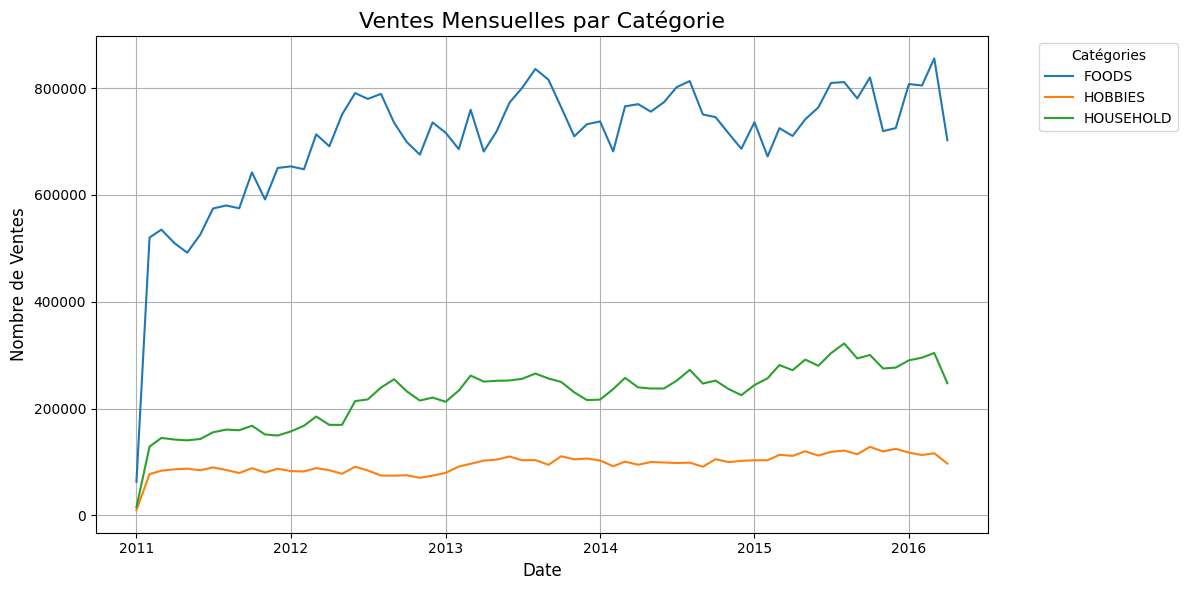

In [6]:
# Calculer le nombre de ventes mensuelles par catégorie
monthly_sales_by_category = df.groupBy("cat_id", "year", "month") \
    .agg(F.sum("sales").alias("total_sales_cat")) \
    .orderBy("cat_id", "year", "month")

monthly_sales_by_category_pd = monthly_sales_by_category.toPandas()
monthly_sales_by_category_pd['date'] = pd.to_datetime(monthly_sales_by_category_pd[['year', 'month']].assign(day=1))

# Tracer les ventes mensuelles par catégorie
plt.figure(figsize=(12, 6))

# Boucle pour tracer chaque catégorie séparément
categories = monthly_sales_by_category_pd['cat_id'].unique()
for category in categories:
    data = monthly_sales_by_category_pd[monthly_sales_by_category_pd['cat_id'] == category]
    plt.plot(data['date'], data['total_sales_cat'], label=category)

# Configuration du graphique
plt.title("Ventes Mensuelles par Catégorie", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Nombre de Ventes", fontsize=12)
plt.legend(title="Catégories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Il est difficile de constater un lien entre la période de l'année et les ventes associées à chaque catégories.

Cependant pour les années 2013 à 2015, on peut remarquer une légère baisse des ventes des catégories HOUSEHOLD et FOODS pendant les périodes de fêtes (et inversement, il y a l'air d'avoir plus de ventes pendant le milieu de l'année, la différence est plus significative pour les ventes de la catégorie food).

## Analyse relations produit-magasin

On récupère tout d'abord les 3 produits les plus vendus à travers toute la chaîne de magasins de Walmart référencée dans cette base de données.

In [7]:
# Calculer les ventes totales par produit
top_products = df.groupBy("item_id") \
    .agg(F.sum("sales").alias("total_sales")) \
    .orderBy(F.desc("total_sales")) \
    .limit(3) # On récupère les trois produits les plus vendus
top_products.show()

+-----------+-----------+
|    item_id|total_sales|
+-----------+-----------+
|FOODS_3_090|    1002529|
|FOODS_3_586|     920242|
|FOODS_3_252|     565299|
+-----------+-----------+



Pour chaque produit de ce top 3, nous calculons le nombre de ventes total dans chaque magasin de ces mêmes produits avant d'afficher les résultats sous forme de dataframe mais également de manière graphique.

+-----------+--------+-----------+
|    item_id|store_id|total_sales|
+-----------+--------+-----------+
|FOODS_3_090|    CA_3|     250502|
|FOODS_3_586|    TX_2|     192835|
|FOODS_3_586|    TX_3|     150122|
|FOODS_3_586|    CA_3|     134386|
|FOODS_3_090|    CA_1|     127203|
|FOODS_3_090|    WI_3|     121434|
|FOODS_3_090|    TX_2|     119496|
|FOODS_3_090|    TX_3|     114854|
|FOODS_3_252|    TX_2|     114153|
|FOODS_3_586|    TX_1|     112454|
|FOODS_3_090|    TX_1|      93684|
|FOODS_3_586|    CA_1|      87691|
|FOODS_3_252|    TX_3|      86632|
|FOODS_3_586|    WI_3|      86080|
|FOODS_3_252|    CA_3|      81456|
|FOODS_3_252|    CA_1|      74971|
|FOODS_3_586|    CA_2|      63416|
|FOODS_3_252|    CA_2|      57328|
|FOODS_3_252|    TX_1|      56294|
|FOODS_3_090|    CA_2|      56169|
+-----------+--------+-----------+
only showing top 20 rows



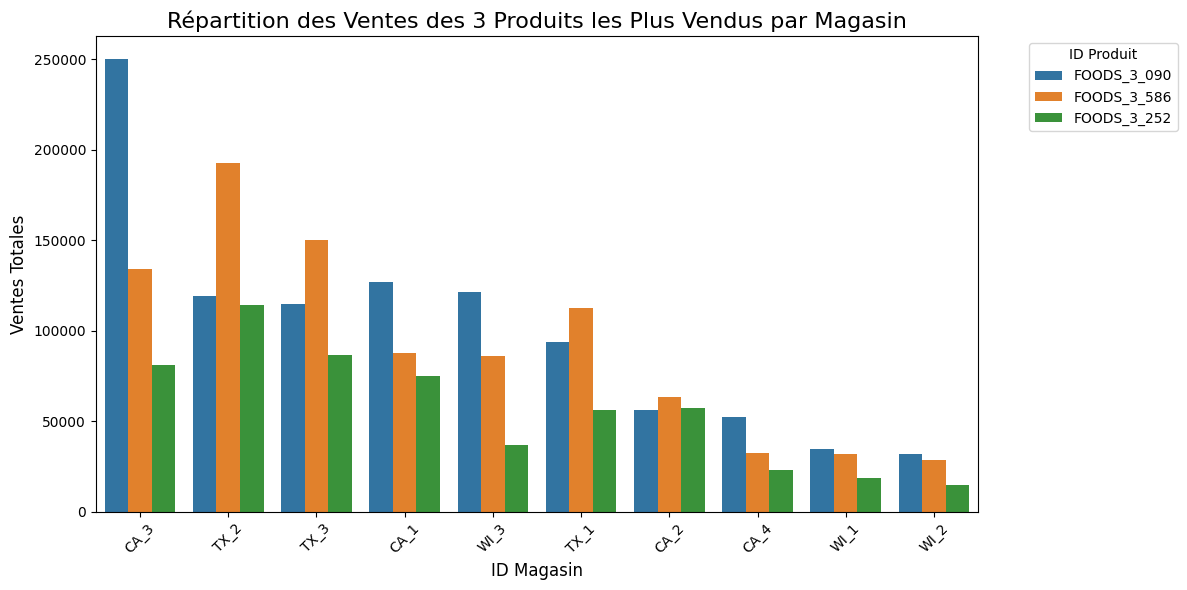

In [8]:
# Filtrer les données pour les 3 produits les plus vendus
top_product_ids = [row['item_id'] for row in top_products.collect()]
filtered_data = df.filter(df["item_id"].isin(top_product_ids))

# Calculer les ventes totales par produit et magasin pour ces 3 produits
product_store_distribution = filtered_data.groupBy("item_id", "store_id") \
    .agg(F.sum("sales").alias("total_sales")) \
    .orderBy(F.desc("total_sales"))

product_store_distribution.show()

# Convertir en Pandas pour visualisation
product_store_distribution_pd = product_store_distribution.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=product_store_distribution_pd, x="store_id", y="total_sales", hue="item_id")

plt.title("Répartition des Ventes des 3 Produits les Plus Vendus par Magasin", fontsize=16)
plt.xlabel("ID Magasin", fontsize=12)
plt.ylabel("Ventes Totales", fontsize=12)
plt.legend(title="ID Produit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les trois produits les plus vendus sont de la catégories FOOD, mais on remarque une grande disparité vis à vis les ventes dans les différents magasins, et ce d'une même région.

Par exemple, FOODS_3_090 a été à l'origine de environ 50 000 ventes dans le magasin CA_4/CA_2 mais atteint plus de 250 000 ventes dans CA_3 (+400%).

Cependant, nous pouvons nous poser la question de si les trois produits sont plus vendus de manière périodique, ou si la vente importante a lieu tout au long de l'année. Nous traçons ainsi les séries temporelles des ventes pour chacun de ces trois produits.

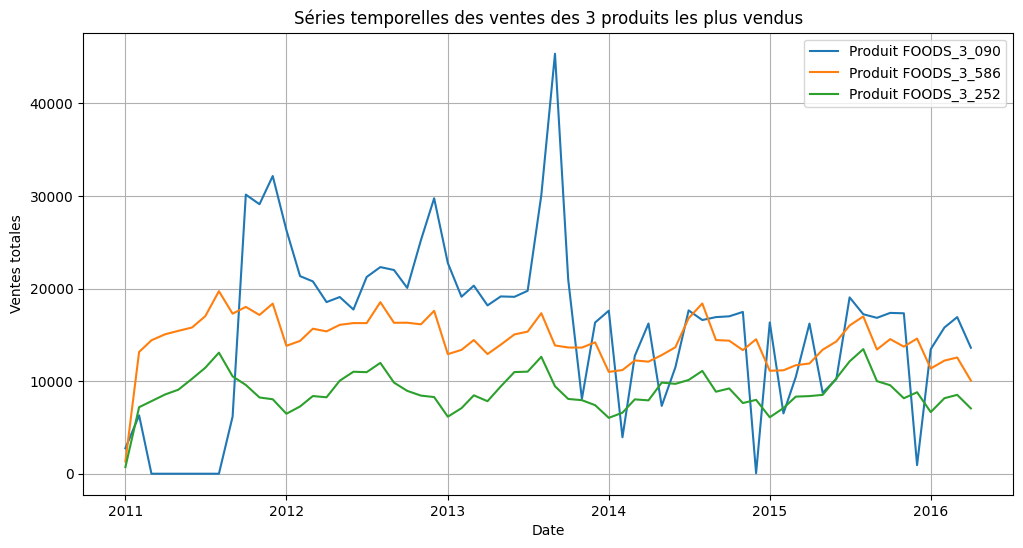

In [36]:
# Tracer les séries temporelles des ventes pour les 3 produits les plus vendus
top_products_sales = df.filter(df["item_id"].isin(top_product_ids)) \
    .groupBy("item_id", "year", "month") \
    .agg(F.sum("sales").alias("total_sales")) \
    .orderBy("item_id", "year", "month")

top_products_sales_pd = top_products_sales.toPandas()
top_products_sales_pd['date'] = pd.to_datetime(top_products_sales_pd[['year', 'month']].assign(day=1))

plt.figure(figsize=(12, 6))
for product_id in top_product_ids:
    product_data = top_products_sales_pd[top_products_sales_pd['item_id'] == product_id]
    plt.plot(product_data['date'], product_data['total_sales'], label=f"Produit {product_id}")

plt.title("Séries temporelles des ventes des 3 produits les plus vendus")
plt.xlabel("Date")
plt.ylabel("Ventes totales")
plt.legend()
plt.grid(True)
plt.show()

Pour les deuxième et troisième produit, le nombre de ventes mensuelles semble plutôt régulier si on omet le premier mois du dataframe puisque uniquement trois jours sont renseignés. Cependant concernant le produits FOODS_3_090, il y a des différences significatives entre deux mois consécutifs et le nombre de ventes varie énormément. On peut donc supposer à une campagne publicitaire sur ce produit effectuée à des périodes précises (fin 2011, fin 2012 et deuxième semestre 2014).

Nous avons aussi d'autres dates pour lesquelles ce même produit (FOODS_3_090) obtient un nombre de ventes proche de 0. Nous pouvons donc penser à une déreférentition de ce produit dans certains magasins, ou à l'essort de nouveaux produits qui ont plus attirés l'oeil du client à partir d'une certaine date.

## Nombre de ventes par magasin

On a vu que concernant le top 3 des produits les plus vendus, il existe des différences significatives de ventes dans les différents magasins. Nous pouvons supposer que les magasins vendant le moins de ces trois produits vendent sûrement d'autres produits, leur permettant ainsi d'avoir un nombre de ventes à peu près équivalent.

Existe donc une différence significative dans les ventes totales des 3049 produits entre chaque magasin ?

Nous récupérons donc tout d'abord les ventes totales de tout les produits pour chacun des 10 magasins, avant d'afficher un histogramme des ventes totales.

<ipython-input-9-4cfefbfcb702>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_total_sales_pd, x="store_id", y="total_sales", palette="viridis")


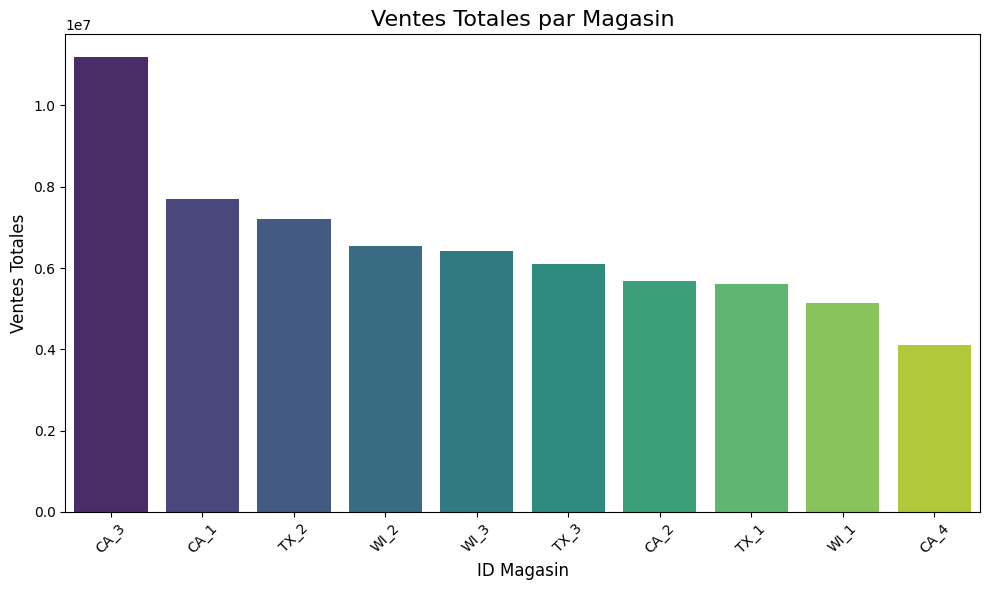

In [9]:
store_total_sales = df.groupBy("store_id") \
    .agg(F.sum("sales").alias("total_sales")) \
    .orderBy(F.desc("total_sales"))

store_total_sales_pd = store_total_sales.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=store_total_sales_pd, x="store_id", y="total_sales", palette="viridis")

plt.title("Ventes Totales par Magasin", fontsize=16)
plt.xlabel("ID Magasin", fontsize=12)
plt.ylabel("Ventes Totales", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On constate que le nombre de ventes dans CA_3 est significativement plus élevé que dans l'ensemble des autres magasins. Qu'en est-il pour les ventes mensuelles ?

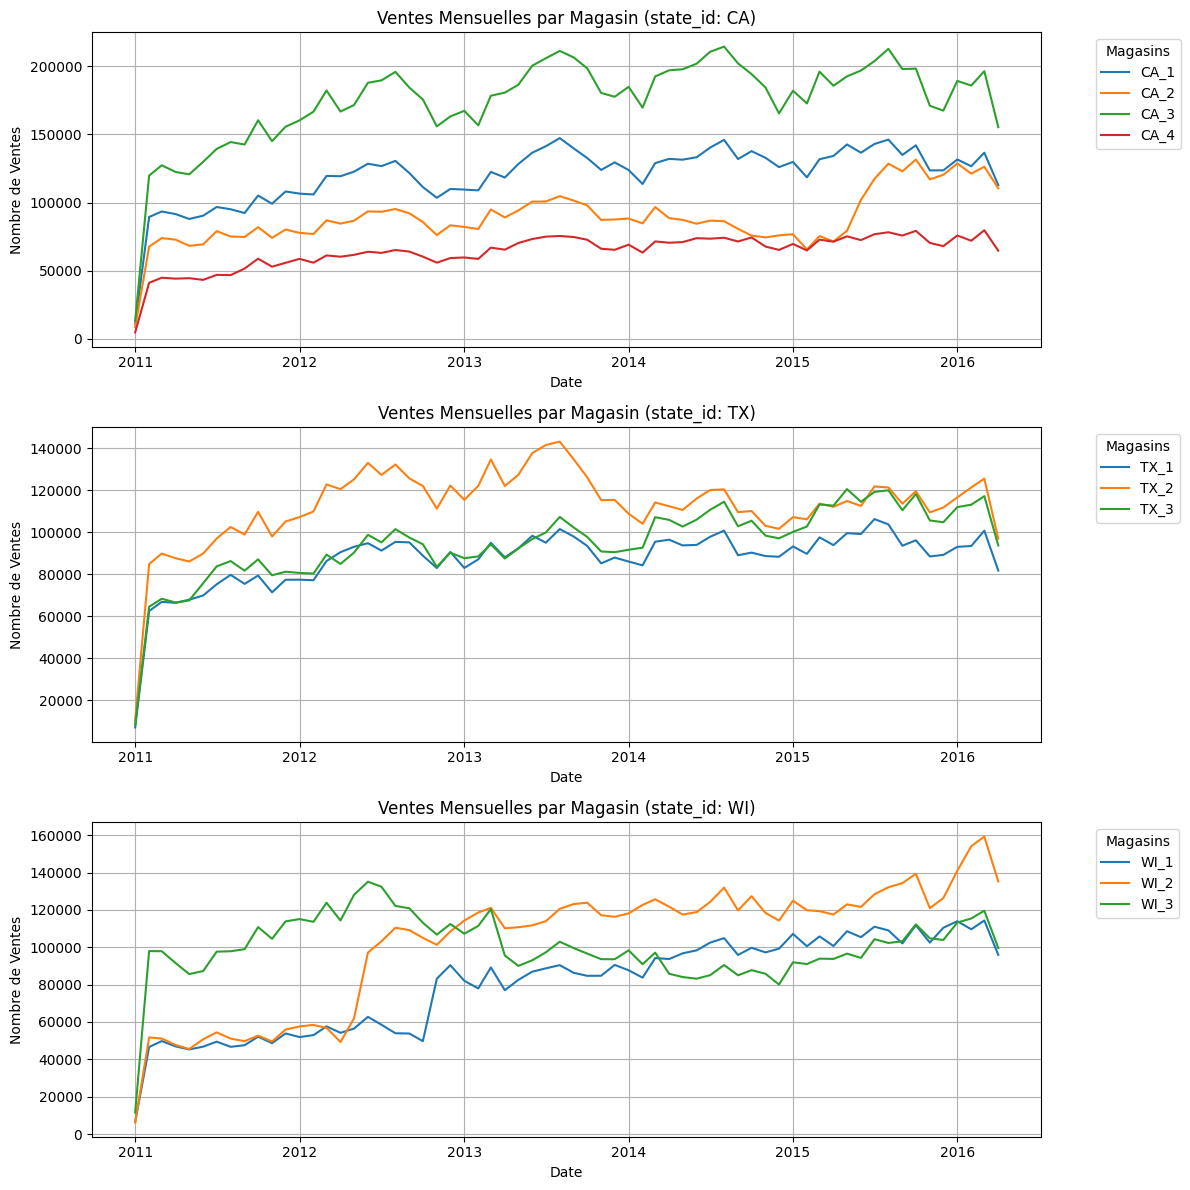

In [10]:
# Calculer les ventes mensuelles par magasin et state_id
monthly_sales_by_store = df.groupBy("store_id", "state_id", "year", "month") \
    .agg(F.sum("sales").alias("total_sales")) \
    .orderBy("store_id", "year", "month")

monthly_sales_by_store_pd = monthly_sales_by_store.toPandas()
monthly_sales_by_store_pd['date'] = pd.to_datetime(monthly_sales_by_store_pd[['year', 'month']].assign(day=1))

state_ids = monthly_sales_by_store_pd['state_id'].unique()

# On divise par state_id le plot | 1 graphique = 1 région
fig, axes = plt.subplots(len(state_ids), 1, figsize=(12, 4 * len(state_ids)))

for i, state_id in enumerate(state_ids):
  # Filtrer les données pour le state_id
  state_data = monthly_sales_by_store_pd[monthly_sales_by_store_pd['state_id'] == state_id]

  # Tracer les ventes mensuelles pour chaque magasin dans le state_id
  for store_id in state_data['store_id'].unique():
    store_data = state_data[state_data['store_id'] == store_id]
    axes[i].plot(store_data['date'], store_data['total_sales'], label=store_id)

  axes[i].set_title(f"Ventes Mensuelles par Magasin (state_id: {state_id})")
  axes[i].set_xlabel("Date")
  axes[i].set_ylabel("Nombre de Ventes")
  axes[i].legend(title="Magasins", bbox_to_anchor=(1.05, 1), loc='upper left')
  axes[i].grid(True)

plt.tight_layout()
plt.show()

Ces graphiques nous permettent de confirmer la différence significative des ventes pour le magasin CA_3 par rapport aux autres magasins. La première et dernière valeurs de chaque graphiques ne doivent pas être prise en compte lors de la phase d'apprentissage du modèle. En effet, le premier et dernier mois rensigné contiennent respectivement 3 et 24 jours, ne représentant pas ainsi le mois entier. Concernant le mois d'avril 2016 donc, on peut ainsi juste obtenir une tendance vis à vis des ventes, à savoir si c'est à la hausse ou à la baisse.  

On remarque également une augmentation importante des ventes pour le magasin WI_2 de l'ordre d'environ 50%. Cette augmentation est retrouvé ci-dessous.

In [20]:
# Jointure entre calendar et sell_prices sur wm_yr_wk
calendar_sell_prices_df = sell_prices_df.join(calendar_df, on="wm_yr_wk", how="inner")
calendar_sell_prices_df = calendar_sell_prices_df.select("store_id", "date", "item_id") \
                                                .filter((F.col("date") >= "2012-01-01") & (F.col("date") <= "2012-12-31")) \
                                                .filter(F.col("store_id") == "WI_2")

# Compte le nombre de produit commercialisé dans le magasin pour chaque mois de l'année 2012
item_id_counts = calendar_sell_prices_df.groupBy(F.month("date").alias("month")) \
                                        .agg(F.countDistinct("item_id").alias("count")) \
                                        .orderBy("month")

# Lag sur le nombre d'item pour calculer le nombre d'items ajouté par mois
item_id_counts = item_id_counts.withColumn("count_lag", F.lag("count").over(Window.orderBy("month")))
item_id_counts = item_id_counts.withColumn("count_diff", F.col("count") - F.col("count_lag"))

# Show the result
item_id_counts.show()

+-----+-----+---------+----------+
|month|count|count_lag|count_diff|
+-----+-----+---------+----------+
|    1| 1541|     NULL|      NULL|
|    2| 1604|     1541|        63|
|    3| 1671|     1604|        67|
|    4| 1821|     1671|       150|
|    5| 1980|     1821|       159|
|    6| 2037|     1980|        57|
|    7| 2095|     2037|        58|
|    8| 2135|     2095|        40|
|    9| 2158|     2135|        23|
|   10| 2172|     2158|        14|
|   11| 2192|     2172|        20|
|   12| 2216|     2192|        24|
+-----+-----+---------+----------+



On remarque que beaucoup de produits ont été ajoutés pendant les mois de mars et avril, on va regrder de manière plus précise si les ventes ont également augmenté à cette période

In [27]:
# Récupère les données de ventes pour le magasin WI_2 pour l'année 2012
filtered_df = monthly_sales_by_store.filter((F.col("store_id") == "WI_2") & (F.col("year") == 2012))
filtered_df.show()

+--------+--------+----+-----+-----------+
|store_id|state_id|year|month|total_sales|
+--------+--------+----+-----+-----------+
|    WI_2|      WI|2012|    1|      57600|
|    WI_2|      WI|2012|    2|      58404|
|    WI_2|      WI|2012|    3|      56815|
|    WI_2|      WI|2012|    4|      49248|
|    WI_2|      WI|2012|    5|      61901|
|    WI_2|      WI|2012|    6|      97162|
|    WI_2|      WI|2012|    7|     103202|
|    WI_2|      WI|2012|    8|     110465|
|    WI_2|      WI|2012|    9|     109152|
|    WI_2|      WI|2012|   10|     105019|
|    WI_2|      WI|2012|   11|     101298|
|    WI_2|      WI|2012|   12|     108465|
+--------+--------+----+-----+-----------+



In [35]:
# Jointure pour récupérer les ventes par mois ainsi que le nombre de produits ajoutés dans le même df
joined_df = filtered_df.join(item_id_counts, on=['month'], how='inner') \
                        .select("month", "total_sales", "count_diff")

# Show the joined dataframe
joined_df.show()

+-----+-----------+----------+
|month|total_sales|count_diff|
+-----+-----------+----------+
|    1|      57600|      NULL|
|    2|      58404|        63|
|    3|      56815|        67|
|    4|      49248|       150|
|    5|      61901|       159|
|    6|      97162|        57|
|    7|     103202|        58|
|    8|     110465|        40|
|    9|     109152|        23|
|   10|     105019|        14|
|   11|     101298|        20|
|   12|     108465|        24|
+-----+-----------+----------+



L'augmentation soudaine du nombre de ventes a eu lieu peu après l'ajout conséquent de produits dans le magasin. On peut donc supposer que l'apparition des produits ainsi qu'une possible re-organisation du magasin soit à l'origine de cette augmentation.